LIBRARIES

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
import cv2 as cv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

OVERALL PARAMETERS (FOR PREPROCESSING AND MODEL BUILDING)

In [2]:
MAIN_SEED = 42  
USE_LESS_DATA = True  
LR = 0.01  
BATCH_SIZE = 32  
EPOCH = 20
IMAGE_RESIZE_X = 200  
IMAGE_RESIZE_Y = 200  
KEEP_COLOR = False  

IMAGE PATHS

In [3]:
training_all_0 = "C-NMC_Leukemia/training_data/fold_0/all/"
training_hem_0 = "C-NMC_Leukemia/training_data/fold_0/hem/"
training_all_1 = "C-NMC_Leukemia/training_data/fold_1/all/"
training_hem_1 = "C-NMC_Leukemia/training_data/fold_1/hem/"
training_all_2 = "C-NMC_Leukemia/training_data/fold_2/all/"
training_hem_2 = "C-NMC_Leukemia/training_data/fold_2/hem/"
validation_data = "C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/"

IMPORTING TRAIN DATA

In [4]:
image_paths = []
image_labels = []
for data_folder_path in [training_all_0,training_all_1,training_all_2,training_hem_0,training_hem_1,training_hem_2]:
    all_images_in_folder = os.listdir(data_folder_path)
    for image_path in all_images_in_folder:
        image_label = 1 if 'all' in data_folder_path else 0
        image_paths.append(data_folder_path + image_path)
        image_labels.append(image_label)

dict_train = {"image_paths":image_paths, "image_labels":image_labels}
df_train = pd.DataFrame(dict_train)
df_train

,image_paths,image_labels
0,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1
1,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1
2,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1
3,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1
4,C-NMC_Leukemia/training_data/fold_0/all/UID_11...,1
...,...,...
10656,C-NMC_Leukemia/training_data/fold_2/hem/UID_H9...,0
10657,C-NMC_Leukemia/training_data/fold_2/hem/UID_H9...,0
10658,C-NMC_Leukemia/training_data/fold_2/hem/UID_H9...,0
10659,C-NMC_Leukemia/training_data/fold_2/hem/UID_H9...,0


IMPORTING VALIDATION DATA

In [5]:
df_val = pd.read_csv('C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
df_val['image_paths'] = df_val['new_names']
df_val['image_labels'] = df_val['labels']
df_val = df_val[['image_paths', 'image_labels']]
df_val['image_paths'] = df_val['image_paths'].apply(lambda x: 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'+x)
df_val

,image_paths,image_labels
0,C-NMC_Leukemia/validation_data/C-NMC_test_prel...,1
1,C-NMC_Leukemia/validation_data/C-NMC_test_prel...,1
2,C-NMC_Leukemia/validation_data/C-NMC_test_prel...,1
3,C-NMC_Leukemia/validation_data/C-NMC_test_prel...,0
4,C-NMC_Leukemia/validation_data/C-NMC_test_prel...,1
...,...,...
1862,C-NMC_Leukemia/validation_data/C-NMC_test_prel...,1
1863,C-NMC_Leukemia/validation_data/C-NMC_test_prel...,1
1864,C-NMC_Leukemia/validation_data/C-NMC_test_prel...,0
1865,C-NMC_Leukemia/validation_data/C-NMC_test_prel...,1


REMOVING BACKGROUND AND COLOR USING OTSU THRESHOLDING

In [6]:
def read_and_crop_image(image_path):
    image = cv.imread(image_path)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    result = cv.bitwise_and(image, image, mask=thresh)
    result[thresh==0] = [255,255,255] 
    (x, y, z_) = np.where(result > 0)
    mnx = (np.min(x))
    mxx = (np.max(x))
    mny = (np.min(y))
    mxy = (np.max(y))
    crop_img = image[mnx:mxx,mny:mxy,:]
    border_v = 0
    border_h = 0
    if (IMAGE_RESIZE_Y/IMAGE_RESIZE_X) >= (crop_img.shape[0]/crop_img.shape[1]):
        border_v = int((((IMAGE_RESIZE_Y/IMAGE_RESIZE_X)*crop_img.shape[1])-crop_img.shape[0])/2)
    else:
        border_h = int((((IMAGE_RESIZE_Y/IMAGE_RESIZE_X)*crop_img.shape[0])-crop_img.shape[1])/2)
    
    crop_img = cv.copyMakeBorder(crop_img, border_v, border_v, border_h, border_h, cv.BORDER_CONSTANT, 0)
    resized_image = cv.resize(crop_img, (IMAGE_RESIZE_X, IMAGE_RESIZE_Y))
    if KEEP_COLOR:
        return resized_image
    else:
        return cv.cvtColor(resized_image, cv.COLOR_BGR2GRAY)
    return resized_image

In [7]:
X_train = df_train['image_paths'].apply(read_and_crop_image).values
X_val = df_val['image_paths'].apply(read_and_crop_image).values
y_train = df_train['image_labels'].values
y_val = df_val['image_labels'].values
X_train = np.stack(X_train, axis=0)
X_val = np.stack(X_val, axis=0)
if not KEEP_COLOR:
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)

TRAIN-TEST SPLIT

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=MAIN_SEED)

MIN-MAX NORMALIZATION

In [9]:
X_train = X_train / 255.0
X_val = X_val / 255.0

SETTING INPUT SHAPE

In [10]:
if len(X_train.shape) > 3:
    input_shape = X_train.shape[1:]
else:
    input_shape = (X_train.shape[1], X_train.shape[2], 1)

TRY 1 - CNN LAYER

In [11]:
first_model = Sequential()
first_model.add(Conv2D(filters = 2, kernel_size = (3,3),padding = 'same',activation ='relu', input_shape = input_shape))
first_model.add(Conv2D(filters = 4, kernel_size = (3,3),padding = 'same',activation ='relu'))
first_model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'same',activation ='relu'))
first_model.add(MaxPool2D(pool_size=(2,2)))
first_model.add(Dropout(0.5))
first_model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'same',activation ='relu'))
first_model.add(MaxPool2D(pool_size=(2,2)))
first_model.add(Conv2D(filters = 24, kernel_size = (7,7),padding = 'same',activation ='relu'))
first_model.add(Dropout(0.5))
first_model.add(Flatten())
first_model.add(Dense(64, kernel_regularizer=l2(1e-5), activation = "relu"))
first_model.add(BatchNormalization())
first_model.add(Dense(32, kernel_regularizer=l2(1e-5), activation = "relu"))
first_model.add(Dense(32, kernel_regularizer=l2(1e-5), activation = "relu"))
first_model.add(Dense(1, activation = "sigmoid"))

In [12]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 2)       20        
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 4)       76        
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 200, 8)       808       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 8)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      3216      
                                                        

In [13]:
optimizer = Adam(lr=LR)
first_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
first_model_trained = first_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs = EPOCH, validation_data = (X_val, y_val))

Epoch 1/20
300/300 [==============================] - 347s 1s/step - loss: 0.6872 - accuracy: 0.6939 - val_loss: 0.8637 - val_accuracy: 0.6369
Epoch 2/20
300/300 [==============================] - 344s 1s/step - loss: 0.6513 - accuracy: 0.7078 - val_loss: 0.9079 - val_accuracy: 0.6524
Epoch 3/20
300/300 [==============================] - 323s 1s/step - loss: 0.6527 - accuracy: 0.7168 - val_loss: 0.9962 - val_accuracy: 0.6369
Epoch 4/20
300/300 [==============================] - 320s 1s/step - loss: 0.6412 - accuracy: 0.7238 - val_loss: 0.7843 - val_accuracy: 0.6079
Epoch 5/20
300/300 [==============================] - 323s 1s/step - loss: 0.6368 - accuracy: 0.7231 - val_loss: 0.8689 - val_accuracy: 0.6261
Epoch 6/20
300/300 [==============================] - 324s 1s/step - loss: 0.6447 - accuracy: 0.7334 - val_loss: 0.8437 - val_accuracy: 0.5988
Epoch 7/20
300/300 [==============================] - 326s 1s/step - loss: 0.6389 - accuracy: 0.7407 - val_loss: 0.7955 - val_accuracy: 0.6502

TRY 2 - CNN LAYER

In [14]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 200, 200, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 320000)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               40960128  
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 40,960,577
Trainable params: 40,960,577
Non-trainable params: 0
__________________________________________

In [15]:
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model_trained = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs = EPOCH, validation_data = (X_val, y_val))

Epoch 1/20
300/300 [==============================] - 161s 535ms/step - loss: 0.6086 - accuracy: 0.6848 - val_loss: 0.7065 - val_accuracy: 0.6508
Epoch 2/20
300/300 [==============================] - 155s 518ms/step - loss: 0.5900 - accuracy: 0.6901 - val_loss: 0.7830 - val_accuracy: 0.6518
Epoch 3/20
300/300 [==============================] - 154s 515ms/step - loss: 0.5781 - accuracy: 0.7004 - val_loss: 0.7555 - val_accuracy: 0.6272
Epoch 4/20
300/300 [==============================] - 155s 516ms/step - loss: 0.5702 - accuracy: 0.7144 - val_loss: 0.7844 - val_accuracy: 0.6272
Epoch 5/20
300/300 [==============================] - 154s 515ms/step - loss: 0.5645 - accuracy: 0.7235 - val_loss: 0.8156 - val_accuracy: 0.6288
Epoch 6/20
300/300 [==============================] - 154s 514ms/step - loss: 0.5544 - accuracy: 0.7333 - val_loss: 0.7494 - val_accuracy: 0.5860
Epoch 7/20
300/300 [==============================] - 156s 520ms/step - loss: 0.5481 - accuracy: 0.7351 - val_loss: 0.8203 -

TRY 3 - CNN LAYER

In [16]:
new_model = Sequential()
new_model.add(Conv2D(32, kernel_size=(3,3), padding= 'same', activation='relu', input_shape= input_shape))
new_model.add(Conv2D(64, kernel_size=(3,3), padding= 'same', activation='relu'))
new_model.add(MaxPool2D(pool_size=(2,2), strides= (2, 2)))
new_model.add(Dropout(0.25))
new_model.add(Conv2D(64,kernel_size=(3,3), padding= 'same', activation='relu'))
new_model.add(MaxPool2D(pool_size=(2,2), strides= (2, 2)))
new_model.add(Dropout(0.25))
new_model.add(Conv2D(128,kernel_size=(3,3), padding= 'same', activation='relu'))
new_model.add(MaxPool2D((2,2), strides= (2, 2)))
new_model.add(Dropout(0.25))
new_model.add(Flatten())
new_model.add(Dense(64))
new_model.add(Dropout(0.5))
new_model.add(Dense(1, activation='sigmoid'))
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 200, 200, 32)      320       
                                                                 
 conv2d_7 (Conv2D)           (None, 200, 200, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 64)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 100, 100, 64)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                  

In [17]:
new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall'])
newmodel_trained = new_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs = EPOCH, validation_data = (X_val, y_val))

Epoch 1/20
300/300 [==============================] - 882s 3s/step - loss: 0.6204 - accuracy: 0.6843 - recall: 0.9703 - val_loss: 0.6893 - val_accuracy: 0.6508 - val_recall: 0.9959
Epoch 2/20
300/300 [==============================] - 866s 3s/step - loss: 0.5904 - accuracy: 0.7026 - recall: 0.9513 - val_loss: 0.6728 - val_accuracy: 0.6524 - val_recall: 0.9992
Epoch 3/20
300/300 [==============================] - 862s 3s/step - loss: 0.5604 - accuracy: 0.7280 - recall: 0.9260 - val_loss: 0.6885 - val_accuracy: 0.6272 - val_recall: 0.9401
Epoch 4/20
300/300 [==============================] - 863s 3s/step - loss: 0.5326 - accuracy: 0.7504 - recall: 0.9140 - val_loss: 0.7448 - val_accuracy: 0.6588 - val_recall: 0.9795
Epoch 5/20
300/300 [==============================] - 863s 3s/step - loss: 0.5176 - accuracy: 0.7590 - recall: 0.9098 - val_loss: 0.6828 - val_accuracy: 0.6524 - val_recall: 0.9221
Epoch 6/20
300/300 [==============================] - 861s 3s/step - loss: 0.4950 - accuracy: 0

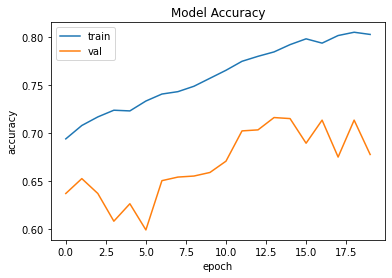

In [18]:
plt.plot(first_model_trained.history['accuracy'])
plt.plot(first_model_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

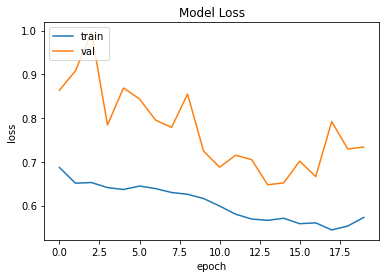

In [19]:
plt.plot(first_model_trained.history['loss'])
plt.plot(first_model_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

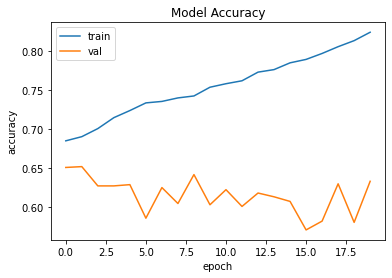

In [20]:
plt.plot(model_trained.history['accuracy'])
plt.plot(model_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

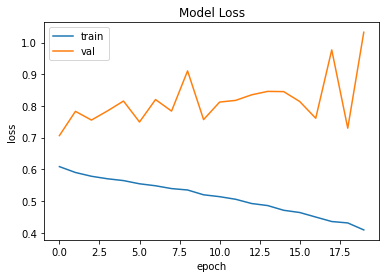

In [21]:
plt.plot(model_trained.history['loss'])
plt.plot(model_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

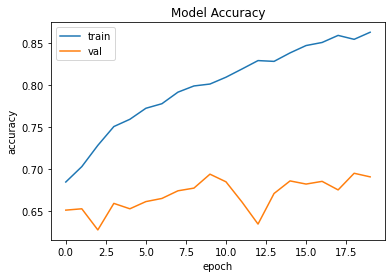

In [22]:
plt.plot(newmodel_trained.history['accuracy'])
plt.plot(newmodel_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

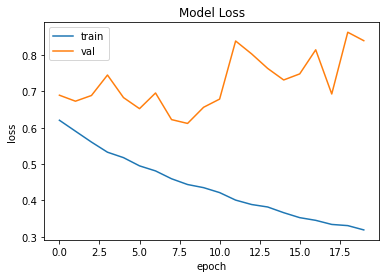

In [23]:
plt.plot(newmodel_trained.history['loss'])
plt.plot(newmodel_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()